In [2]:
import warnings
import os
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt

import numpy as np
from scipy.io import loadmat
import hdf5storage

import pandas as pd
import re

# Transformations
from timescales.sim import bin_spikes
from neurodsp.spectral import compute_spectrum
from timescales.autoreg import compute_ar_spectrum
from statsmodels.tsa.stattools import acf

# Workflow
from ndspflow.workflows import WorkFlow

# Models
from timescales.fit import PSD, ACF

#import functions for ndsp workflow

from timescale_ndsp_func import reader
from timescale_ndsp_func import compute_acf
from timescale_ndsp_func import bin_spikes
from timescale_ndsp_func import bin_spikes
from timescale_ndsp_func import compute_ar_spectrum_
from timescale_ndsp_func import mean

In [3]:
def remove_nans(taus, divs, cultures, objs):
    #remove NaNs
    divs = divs[~np.isnan(taus)]
    cultures = cultures[~np.isnan(taus)]
    objs = objs[~np.isnan(taus)]
    taus = taus[~np.isnan(taus)]
    
    
    return [taus, divs, cultures, objs]

In [4]:
def remove_outliers(taus, divs, cultures, objs):
    
    
    
    
    #remove extreme outliers
    outliers = 100*np.median(taus)
    print(outliers)

    divs = divs[taus<=outliers]
    cultures = cultures[taus<=outliers]
    objs = objs[taus<=outliers]
    
    taus = taus[taus<=outliers]
    
    
    
    return [taus, divs, cultures, objs]

In [5]:
def get_mean_std_well(taus, divs, cultures):
    
  
    
    sort_cultures = sorted(set(cultures))

    all_cults  = []
    all_divs = []
    all_mean_taus = []
    all_std_taus = []

    #get indices for each culture

    for c in sort_cultures:
   
        indices = [i for i, x in enumerate(cultures) if x == c]
  
    
        
        #get divs for each culture 
        cult_divs = divs[indices]
        
        #get mean tau for each div in culture
        
        sort_divs = sorted(set(cult_divs))
        
        for d in sort_divs:
            indices_d = [i for i, x in enumerate(cult_divs) if x == d]
            
            #get taus for that day 
            taus_dc = taus[indices_d]
            
            
            #get mean and standard deviation for that day 
            mean_taus = np.mean(taus_dc)
            std_taus = np.std(taus_dc)
            
            all_cults.append(c)
            all_divs.append(d)
            all_mean_taus.append(mean_taus)
            all_std_taus.append(std_taus)
     
        
        
       
        
    return [all_cults, all_divs, all_mean_taus, all_std_taus]

In [6]:
def get_mean_std_recday (taus, divs):
    days = sorted(set(divs))
    all_indices = []
    days_taus = []
    mean_taus = []
    std_taus = []

    #get indices for each day

    for d in days:
   
        indices = [i for i, x in enumerate(divs) if x == d]
        
        all_indices.append(indices)
        #get taus for those indices
        day_taus = taus[indices]
        days_taus.append(day_taus)
        #get means and stds
        mean_taus.append(np.mean(day_taus))
        std_taus.append(np.std(day_taus))
        
    return [days, all_indices, days_taus, mean_taus, std_taus]

In [7]:
# Paths
dirpath = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid-tango/hc-8/rat_organoid_timescale_development_paper/hc8_data/'
files = [f for f in sorted(os.listdir(dirpath)) if f.endswith('.npy')]

In [8]:
# Settings
fs = 20000
bin_size = 200
fs_bin = fs / bin_size
bins_per_window = 1000

# Get indices of all files + neurons
n_neurons = np.array([len(reader(i)) for i in range(len(files))])

cultures = []
divs = []

for f in range(len(files)):
    #get div and culture number for each recording
    splt = files[f].split('Culture')[1]
    splt = splt.split('DIV')
    culture = int(splt[0])
    div = int(splt[1].split('.')[0])
    
    for n in range(n_neurons[f]):

        cultures.append(culture)
        divs.append(div)

indices = np.array(
    [[i_file, i_neuron] for i_file in range(len(files))
     for i_neuron in range(n_neurons[i_file])]
)

In [9]:

# Welch PSD directory
pickle_dir_w = "/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid-tango/organoid-tango/wPSD_fits_pkl_new/"
# AR PSD directory
pickle_dir_ar = "/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid-tango/organoid-tango/arPSD_fits_pkl_new/"

# Init workflow
wf = WorkFlow()

# Read .mat files
wf.read_raw(reader, indices)

# Bin spikes and window
wf.transform(bin_spikes, bin_size, bins_per_window)

# PSD (Welch's)
wf.fork(0)
wf.transform(compute_spectrum, fs_bin, axis=1, f_range=(.001, 200))
wf.transform(mean, axis=0)
wf.fit(PSD(), pickle=True, pickle_dir=pickle_dir_w)

# PSD (AR)
sigma = np.zeros(2048-1)
sigma[:100] = .01
sigma[100:] = 1

wf.fork(0)
wf.transform(compute_ar_spectrum_, fs_bin, 10, axis=1, f_range=(.001, 200))
wf.transform(mean, axis=0)
wf.fit(PSD(),  pickle=True, pickle_dir=pickle_dir_ar, sigma=sigma)

wf.run(n_jobs=-1, progress=tqdm)

Running Workflow:   0%|          | 0/39529 [00:00<?, ?it/s]

Process SpawnPoolWorker-2:
Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/blancamartin/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/blancamartin/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/blancamartin/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/blancamartin/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
  File "/Users/blancamartin/Desktop/Voytek_Lab/ndspflow/ndspflow/workflows/__init__.py", line 3, in <module>
    from .workflow import WorkFlow
  File "/Users/blancamartin/Desktop/Voytek_Lab/ndspflow/ndspflow/workflows/workflow.py", line 14, in <module>
    from mne_bids import BIDSPath
  File "/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/mne_bids/__init__.py", 

KeyboardInterrupt: 

### Read saved pickle files 

In [10]:
pickle_dir_w = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid-tango/organoid-tango/wPSD_fits_pkl_new/'
pickle_dir_ar = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid-tango/organoid-tango/arPSD_fits_pkl_new/'



In [11]:
wPSD_tau = []
wPSD = []

for filename in sorted(os.listdir(pickle_dir_w)):
    f = os.path.join(pickle_dir_w, filename)
    obj = pd.read_pickle(f)
    wPSD_tau.append(obj.tau)
    wPSD.append(obj)
    


In [12]:
#remove NaNs 
wPSD_tau, wdivs, wcultures,wPSD = remove_nans(np.asarray(wPSD_tau), np.asarray(divs), np.asarray(cultures), np.asarray(wPSD))


In [13]:
arPSD_tau = []
arPSD = []

for filename in sorted(os.listdir(pickle_dir_ar)):
    f = os.path.join(pickle_dir_ar, filename)
    obj = pd.read_pickle(f)
    arPSD_tau.append(obj.tau)
    arPSD.append(obj)

In [14]:
#remove NaNs 
arPSD_tau, ardivs, arcultures,arPSD = remove_nans(np.asarray(arPSD_tau), np.asarray(divs), np.asarray(cultures), np.asarray(arPSD))


### Plot timescales over development 

#### Before removing outliers

Text(0.5, 0, 'divs')

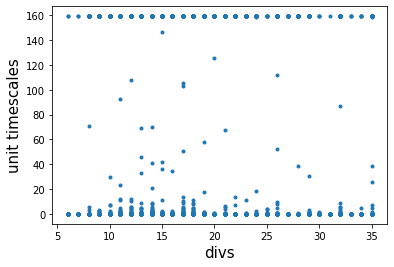

In [15]:
plt.plot(wdivs, wPSD_tau, '.')
plt.ylabel('unit timescales', size=15)
plt.xlabel('divs', size=15)

Text(0.5, 0, 'divs')

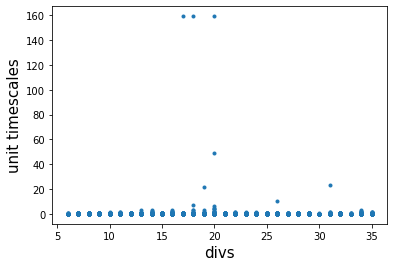

In [16]:
plt.plot(ardivs, arPSD_tau, '.')
plt.ylabel('unit timescales', size=15)
plt.xlabel('divs', size=15)

#### Afer removing outliers

0.653461477562702


Text(0.5, 0, 'divs')

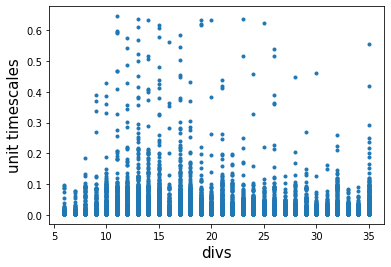

In [17]:
#remove outliers 
wPSD_tau_rem, wdivs_rem, wcultures_rem, wPSD_rem = remove_outliers(np.asarray(wPSD_tau), np.asarray(wdivs), np.asarray(wcultures), np.asarray(wPSD))

plt.plot(wdivs_rem, wPSD_tau_rem, '.')
plt.ylabel('unit timescales', size=15)
plt.xlabel('divs', size=15)




1.0915432584889437


Text(0.5, 0, 'divs')

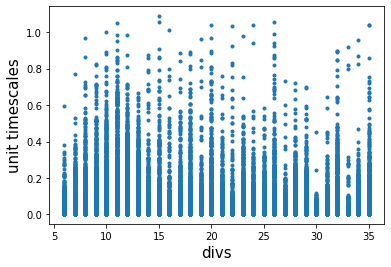

In [18]:
#remove outliers 
arPSD_tau_rem, ardivs_rem, arcultures_rem, arPSD_rem = remove_outliers(np.asarray(arPSD_tau), np.asarray(ardivs), np.asarray(arcultures), np.asarray(arPSD))

plt.plot(ardivs_rem, arPSD_tau_rem, '.')
plt.ylabel('unit timescales', size=15)
plt.xlabel('divs', size=15)



### Get mean and stds for each culture

In [19]:
meanstd_wPSD = get_mean_std_well(np.asarray(wPSD_tau_rem), np.asarray(wdivs_rem), np.asarray(wcultures_rem) 
                             )

In [20]:
meanstd_arPSD = get_mean_std_well(np.asarray(arPSD_tau_rem), np.asarray(ardivs_rem), np.asarray(arcultures_rem) )


#### Plot mean culture timescales in linear scale 

Text(0.5, 1.0, "Culture timescales Welch's PSD")

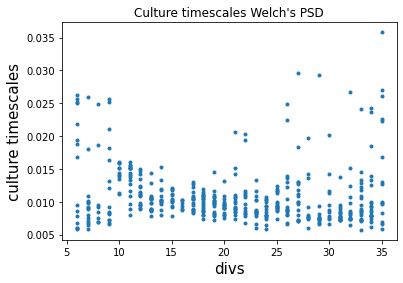

In [21]:
plt.plot(meanstd_wPSD[1], meanstd_wPSD[2], '.')
plt.ylabel('culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Culture timescales Welch's PSD")

Text(0.5, 1.0, 'Culture timescales AR PSD')

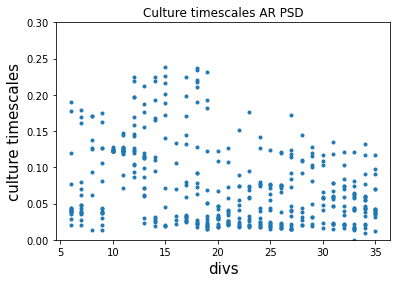

In [22]:
plt.plot(meanstd_arPSD[1], meanstd_arPSD[3], '.')

plt.ylabel('culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.ylim(0,0.3)
plt.title("Culture timescales AR PSD")

#### Plot mean culture timescales in log scale

Text(0.5, 1.0, "Log culture timescales Welch's PSD")

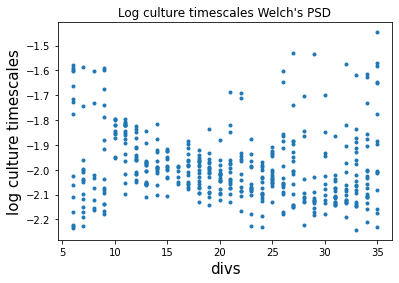

In [23]:
plt.plot(meanstd_wPSD[1], np.log10(meanstd_wPSD[2]), '.')
plt.ylabel('log culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Log culture timescales Welch's PSD")

Text(0.5, 1.0, 'Log culture timescales AR PSD')

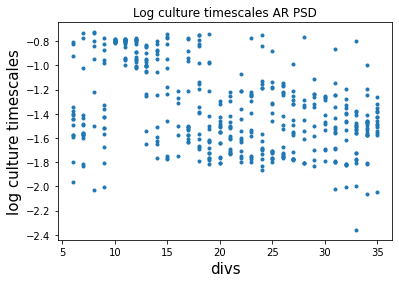

In [24]:
plt.plot(meanstd_arPSD[1], np.log10(meanstd_arPSD[2]), '.')
plt.ylabel('log culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Log culture timescales AR PSD")

#### Plot mean culture timescales with standard deviation error bars in linear scale

Text(0.5, 1.0, "Linear culture timescales Welch's PSD")

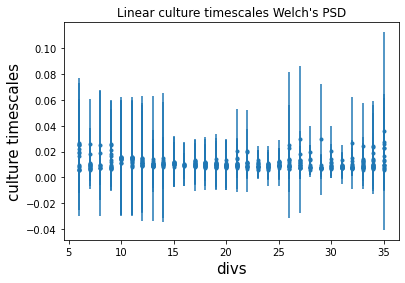

In [25]:
plt.errorbar(meanstd_wPSD[1],meanstd_wPSD[2], meanstd_wPSD[3], linestyle='None', marker='.')
plt.ylabel('culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Linear culture timescales Welch's PSD")


Text(0.5, 1.0, 'Linear culture timescales AR PSD')

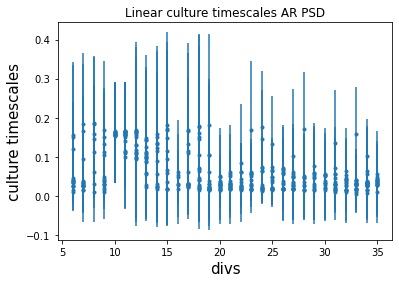

In [26]:
plt.errorbar(meanstd_arPSD[1],meanstd_arPSD[2], meanstd_arPSD[3], linestyle='None', marker='.')
plt.ylabel('culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Linear culture timescales AR PSD")

#### Plot mean culture timescales with standard deviation error bars in log scale

Text(0.5, 1.0, "Log  culture timescales Welch's PSD")

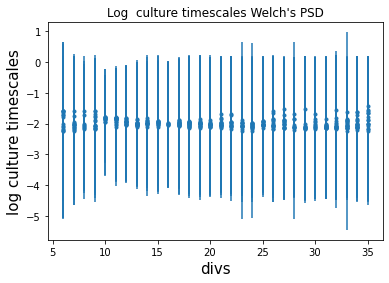

In [27]:
plt.errorbar(meanstd_wPSD[1],np.log10(meanstd_wPSD[2]), np.log10(meanstd_wPSD[3]), linestyle='None', marker='.')
plt.ylabel('log culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Log  culture timescales Welch's PSD")

Text(0.5, 1.0, 'Log culture timescales AR PSD')

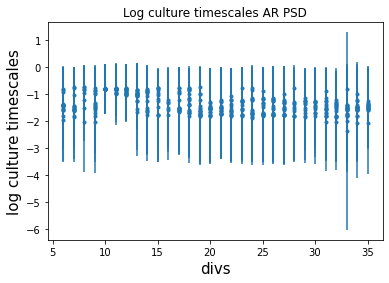

In [28]:
plt.errorbar(meanstd_arPSD[1],np.log10(meanstd_arPSD[2]), np.log10(meanstd_arPSD[3]), linestyle='None', marker='.')
plt.ylabel('log culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Log culture timescales AR PSD")


### Look at fits 

In [29]:
## show attributes
wPSD[0].__dir__()

['freqs',
 'powers',
 'powers_fit',
 'params',
 'param_names',
 'knee_freq',
 'tau',
 'rsq',
 'rsq_full',
 'guess',
 'bounds',
 '__module__',
 '__doc__',
 '__init__',
 'compute_spectrum',
 'fit',
 'plot',
 '__dict__',
 '__weakref__',
 '__slotnames__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

#### Look into 160s wPSD artifacts

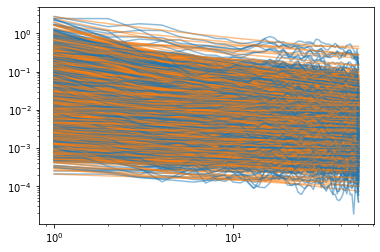

In [30]:
for w in range(len(wPSD_tau)):
    
    if wPSD_tau[w] > 155:
        #show fits for those indices
        plt.loglog(wPSD[w].freqs, wPSD[w].powers, color='C0', alpha=.5)
        plt.loglog(wPSD[w].freqs, wPSD[w].powers_fit, color='C1', alpha=.5)
        

#### Get r-squared values of fits

In [31]:
rsq_wPSD = []
rsq_arPSD = []

rsq_full_wPSD = []
rsq_full_arPSD = []


for w in wPSD:
    rsq_wPSD.append(w.rsq)
    rsq_full_wPSD.append(w.rsq_full)
    
for ar in arPSD:
    rsq_arPSD.append(ar.rsq)
    rsq_full_arPSD.append(ar.rsq_full)
    

    

#### plot distribution of r-squared values 

(array([4240., 2036., 2889., 3255., 3220., 3279., 3707., 4560., 6046.,
        6286.]),
 array([3.38999515e-32, 9.95856930e-02, 1.99171386e-01, 2.98757079e-01,
        3.98342772e-01, 4.97928465e-01, 5.97514158e-01, 6.97099851e-01,
        7.96685544e-01, 8.96271237e-01, 9.95856930e-01]),
 <BarContainer object of 10 artists>)

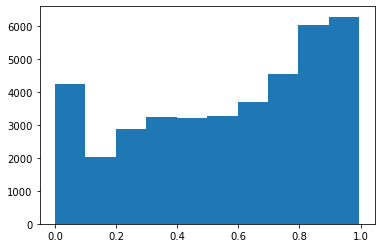

In [32]:
#Welch's PSD
plt.hist(rsq_wPSD)

(array([ 2942.,  2024.,  1989.,  1890.,  2084.,  2416.,  2942.,  4054.,
         6120., 13067.]),
 array([1.04829523e-31, 9.99542381e-02, 1.99908476e-01, 2.99862714e-01,
        3.99816953e-01, 4.99771191e-01, 5.99725429e-01, 6.99679667e-01,
        7.99633905e-01, 8.99588143e-01, 9.99542381e-01]),
 <BarContainer object of 10 artists>)

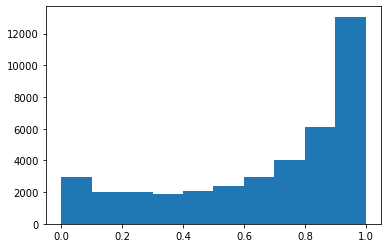

In [33]:
#AR PSD

plt.hist(rsq_arPSD)

#### Look at bad fits (rsq < 0.8)

In [34]:
"""
# Welch's PSD

#plot in sets of 20 

num = 0 

for r in range(len(rsq_wPSD)):
    
    if rsq_wPSD[r] < 0.8:
        #show fits for those indices
        """
        plt.loglog(wPSD[r].freqs, wPSD[r].powers, color='C0', alpha=.5)
        plt.loglog(wPSD[r].freqs, wPSD[r].powers_fit, color='C1', alpha=.5)"""
        
        if num == 20:
            plt.show()
            num = -1
        
        num = num + 1"""
        

IndentationError: unexpected indent (3286371244.py, line 13)

In [35]:
"""
# AR PSD

#plot in sets of 20 

num = 0 

for r in range(len(rsq_arPSD)):
    
    if rsq_arPSD[r] < 0.8:
        #show fits for those indices
        plt.loglog(arPSD[r].freqs, arPSD[r].powers, color='C0', alpha=.5)
        plt.loglog(arPSD[r].freqs, arPSD[r].powers_fit, color='C1', alpha=.5)
        
        if num == 20:
            plt.show()
            num = -1
        
        num = num + 1
        """

"\n# AR PSD\n\n#plot in sets of 20 \n\nnum = 0 \n\nfor r in range(len(rsq_arPSD)):\n    \n    if rsq_arPSD[r] < 0.8:\n        #show fits for those indices\n        plt.loglog(arPSD[r].freqs, arPSD[r].powers, color='C0', alpha=.5)\n        plt.loglog(arPSD[r].freqs, arPSD[r].powers_fit, color='C1', alpha=.5)\n        \n        if num == 20:\n            plt.show()\n            num = -1\n        \n        num = num + 1\n        "

#### Look at good fits (rsq >= 0.8)

In [36]:
""" # Welch's PSD

#plot in sets of 20 
wdivs_gfits = []
wcultures_gfits = []
wPSD_gfits = []
wtau_gfits = []
wrsq_gfits = []

num = 0 

for r in range(len(rsq_wPSD)):
    
    if rsq_wPSD[r] >= 0.8:
        
        wdivs_gfits.append(wdivs[r])
        wcultures_gfits.append(wcultures[r])
        wPSD_gfits.append(wPSD[r])
        wrsq_gfits.append(rsq_wPSD[r])
        wtau_gfits.append(wPSD_tau[r])
        

        #show fits for those indices
        plt.loglog(wPSD[r].freqs, wPSD[r].powers, color='C0', alpha=.5)
        plt.loglog(wPSD[r].freqs, wPSD[r].powers_fit, color='C1', alpha=.5)
        
        if num == 20:
            plt.show()
            num = -1
        
        num = num + 1"""
        
        

" # Welch's PSD\n\n#plot in sets of 20 \nwdivs_gfits = []\nwcultures_gfits = []\nwPSD_gfits = []\nwtau_gfits = []\nwrsq_gfits = []\n\nnum = 0 \n\nfor r in range(len(rsq_wPSD)):\n    \n    if rsq_wPSD[r] >= 0.8:\n        \n        wdivs_gfits.append(wdivs[r])\n        wcultures_gfits.append(wcultures[r])\n        wPSD_gfits.append(wPSD[r])\n        wrsq_gfits.append(rsq_wPSD[r])\n        wtau_gfits.append(wPSD_tau[r])\n        \n\n        #show fits for those indices\n        plt.loglog(wPSD[r].freqs, wPSD[r].powers, color='C0', alpha=.5)\n        plt.loglog(wPSD[r].freqs, wPSD[r].powers_fit, color='C1', alpha=.5)\n        \n        if num == 20:\n            plt.show()\n            num = -1\n        \n        num = num + 1"

In [37]:
"""# AR PSD
ardivs_gfits = []
arcultures_gfits = []
arPSD_gfits = []
artau_gfits = []
arrsq_gfits = []

#plot in sets of 20 

num = 0 

for r in range(len(rsq_arPSD)):
    
    if rsq_arPSD[r] >= 0.8:
        #show fits for those indices
        plt.loglog(arPSD[r].freqs, arPSD[r].powers, color='C0', alpha=.5)
        plt.loglog(arPSD[r].freqs, arPSD[r].powers_fit, color='C1', alpha=.5)
        
        ardivs_gfits.append(ardivs[r])
        arcultures_gfits.append(arcultures[r])
        arPSD_gfits.append(arPSD[r])
        arrsq_gfits.append(rsq_arPSD[r])
        artau_gfits.append(arPSD_tau[r])
        
        
        if num == 20:
            plt.show()
            num = -1
        
        num = num + 1"""
        
        
        

"# AR PSD\nardivs_gfits = []\narcultures_gfits = []\narPSD_gfits = []\nartau_gfits = []\narrsq_gfits = []\n\n#plot in sets of 20 \n\nnum = 0 \n\nfor r in range(len(rsq_arPSD)):\n    \n    if rsq_arPSD[r] >= 0.8:\n        #show fits for those indices\n        plt.loglog(arPSD[r].freqs, arPSD[r].powers, color='C0', alpha=.5)\n        plt.loglog(arPSD[r].freqs, arPSD[r].powers_fit, color='C1', alpha=.5)\n        \n        ardivs_gfits.append(ardivs[r])\n        arcultures_gfits.append(arcultures[r])\n        arPSD_gfits.append(arPSD[r])\n        arrsq_gfits.append(rsq_arPSD[r])\n        artau_gfits.append(arPSD_tau[r])\n        \n        \n        if num == 20:\n            plt.show()\n            num = -1\n        \n        num = num + 1"

#### Look at 20 worst fits for each method, and the corresponding fits in other method

In [38]:
"""# worst fits Welch's PSD

worst_fits_wPSD_idx = np.argpartition(rsq_wPSD, 20)[:20]

worstf_wPSD = np.asarray(rsq_wPSD)[worst_fits_wPSD_idx]
worstf_wPSD_corr_arPSD = np.asarray(rsq_arPSD)[worst_fits_wPSD_idx]

#plot 20 worst Welch PSD fits and correspoding AR PSD fits

for i in worst_fits_wPSD_idx:
    plt.loglog(wPSD[i].freqs, wPSD[i].powers, color='C0', alpha=.5)
    plt.loglog(wPSD[i].freqs, wPSD[i].powers_fit, color='C1', alpha=.5)
    plt.title("Welch's PSD for index " + str(i))
    plt.show()
    
    plt.loglog(arPSD[i].freqs, arPSD[i].powers, color='C0', alpha=.5)
    plt.loglog(arPSD[i].freqs, arPSD[i].powers_fit, color='C1', alpha=.5)
    plt.title("AR PSD for index " + str(i))
    plt.show()
    
"""


'# worst fits Welch\'s PSD\n\nworst_fits_wPSD_idx = np.argpartition(rsq_wPSD, 20)[:20]\n\nworstf_wPSD = np.asarray(rsq_wPSD)[worst_fits_wPSD_idx]\nworstf_wPSD_corr_arPSD = np.asarray(rsq_arPSD)[worst_fits_wPSD_idx]\n\n#plot 20 worst Welch PSD fits and correspoding AR PSD fits\n\nfor i in worst_fits_wPSD_idx:\n    plt.loglog(wPSD[i].freqs, wPSD[i].powers, color=\'C0\', alpha=.5)\n    plt.loglog(wPSD[i].freqs, wPSD[i].powers_fit, color=\'C1\', alpha=.5)\n    plt.title("Welch\'s PSD for index " + str(i))\n    plt.show()\n    \n    plt.loglog(arPSD[i].freqs, arPSD[i].powers, color=\'C0\', alpha=.5)\n    plt.loglog(arPSD[i].freqs, arPSD[i].powers_fit, color=\'C1\', alpha=.5)\n    plt.title("AR PSD for index " + str(i))\n    plt.show()\n    \n'

In [39]:
"""# worst fits AR PSD

worst_fits_arPSD_idx = np.argpartition(rsq_arPSD, 20)[:20]

worstf_arPSD = np.asarray(rsq_arPSD)[worst_fits_arPSD_idx]
worstf_arPSD_corr_wPSD = np.asarray(rsq_wPSD)[worst_fits_arPSD_idx]

#plot 20 worst Welch PSD fits and correspoding AR PSD fits

for i in worst_fits_arPSD_idx:
    plt.loglog(arPSD[i].freqs, arPSD[i].powers, color='C0', alpha=.5)
    plt.loglog(arPSD[i].freqs, arPSD[i].powers_fit, color='C1', alpha=.5)
    plt.title("AR PSD for index " + str(i))
    plt.show()
    
    plt.loglog(wPSD[i].freqs, wPSD[i].powers, color='C0', alpha=.5)
    plt.loglog(wPSD[i].freqs, wPSD[i].powers_fit, color='C1', alpha=.5)
    plt.title("Corresponding Welch's PSD for index " + str(i))
    plt.show()
    
"""

'# worst fits AR PSD\n\nworst_fits_arPSD_idx = np.argpartition(rsq_arPSD, 20)[:20]\n\nworstf_arPSD = np.asarray(rsq_arPSD)[worst_fits_arPSD_idx]\nworstf_arPSD_corr_wPSD = np.asarray(rsq_wPSD)[worst_fits_arPSD_idx]\n\n#plot 20 worst Welch PSD fits and correspoding AR PSD fits\n\nfor i in worst_fits_arPSD_idx:\n    plt.loglog(arPSD[i].freqs, arPSD[i].powers, color=\'C0\', alpha=.5)\n    plt.loglog(arPSD[i].freqs, arPSD[i].powers_fit, color=\'C1\', alpha=.5)\n    plt.title("AR PSD for index " + str(i))\n    plt.show()\n    \n    plt.loglog(wPSD[i].freqs, wPSD[i].powers, color=\'C0\', alpha=.5)\n    plt.loglog(wPSD[i].freqs, wPSD[i].powers_fit, color=\'C1\', alpha=.5)\n    plt.title("Corresponding Welch\'s PSD for index " + str(i))\n    plt.show()\n    \n'

#### Look at 20 best fits for each method, and the corresponding fits in other method - FIXXX 

In [483]:
~np.isnan(rsq_wPSD)

array([ True,  True,  True, ...,  True,  True,  True])

In [455]:
np.argpartition(~np.isnan(rsq_wPSD), -20)[-20:]


array([13186, 13202, 13167, 13183, 13182, 13181, 13180, 13179, 13178,
       13177, 13176, 13175, 13174, 13173, 13172, 13171, 13170, 13169,
       13168, 39527])

In [494]:
#get indices of 20 best fits

not_nan_wPSD_idx = ~np.isnan(rsq_wPSD)

best_fits_wPSD_idx = np.argpartition(rsq_wPSD, 40)

best_fits_wPSD_idx_notnan = []

for i in range(len(best_fits_wPSD_idx)):
    if not_nan_wPSD_idx[best_fits_wPSD_idx[i]]:
        
        best_fits_wPSD_idx_notnan.append(best_fits_wPSD_idx[i])

In [496]:
wPSD_tau[best_fits_wPSD_idx_notnan[-20:]]

array([0.01680268, 0.00840257, 0.00565056, 0.01094687, 0.00630541,
       0.01141575, 0.00698395, 0.00704515, 0.00975566, 0.01113029,
       0.00727224, 0.00639652, 0.00999817, 0.00625279, 0.00684982,
       0.00666645, 0.00721133, 0.00861774, 0.00710823, 0.00555011])

In [40]:
# best fits Welch's PSD
"""

#plot 20 best Welch PSD fits and correspoding AR PSD fits

for i in best_fits_wPSD_idx_notnan[-20:]:
    
    plt.loglog(wPSD[i].freqs, wPSD[i].powers, color='C0', alpha=.5)
    plt.loglog(wPSD[i].freqs, wPSD[i].powers_fit, color='C1', alpha=.5)
    plt.title("Welch's PSD for index " + str(i))
    plt.show()
    
    plt.loglog(arPSD[i].freqs, arPSD[i].powers, color='C0', alpha=.5)
    plt.loglog(arPSD[i].freqs, arPSD[i].powers_fit, color='C1', alpha=.5)
    plt.title("AR PSD for index " + str(i))
    plt.show()
  """  


'\n\n#plot 20 best Welch PSD fits and correspoding AR PSD fits\n\nfor i in best_fits_wPSD_idx_notnan[-20:]:\n    \n    plt.loglog(wPSD[i].freqs, wPSD[i].powers, color=\'C0\', alpha=.5)\n    plt.loglog(wPSD[i].freqs, wPSD[i].powers_fit, color=\'C1\', alpha=.5)\n    plt.title("Welch\'s PSD for index " + str(i))\n    plt.show()\n    \n    plt.loglog(arPSD[i].freqs, arPSD[i].powers, color=\'C0\', alpha=.5)\n    plt.loglog(arPSD[i].freqs, arPSD[i].powers_fit, color=\'C1\', alpha=.5)\n    plt.title("AR PSD for index " + str(i))\n    plt.show()\n  '

### Show results over development only with good fits (rsq > = 0.8)

#### Before removing outliers 

Text(0.5, 1.0, "Welch's PSD good fits before removing outliers ")

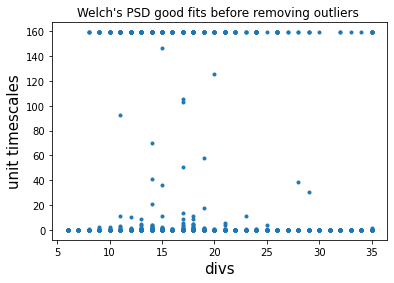

In [461]:
plt.plot(wdivs_gfits, wtau_gfits, '.')
plt.ylabel('unit timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Welch's PSD good fits before removing outliers ")

Text(0.5, 1.0, 'AR PSD good fits before removing outliers ')

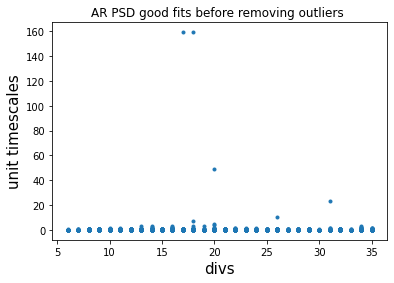

In [462]:
plt.plot(ardivs_gfits, artau_gfits, '.')
plt.ylabel('unit timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("AR PSD good fits before removing outliers ")

#### After removing outliers 

0.8455103897554583


Text(0.5, 1.0, "Welch's PSD good fits after removing outliers ")

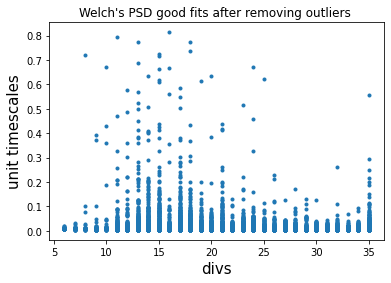

In [465]:
#remove outliers 
wtau_rem_gf, wdivs_rem_gf, wcultures_rem_gf, wPSD_rem_gf = remove_outliers(np.asarray(wtau_gfits), np.asarray(wdivs_gfits), np.asarray(wcultures_gfits), np.asarray(wPSD_gfits))

plt.plot(wdivs_rem_gf, wtau_rem_gf, '.')
plt.ylabel('unit timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Welch's PSD good fits after removing outliers ")


0.9768437959571851


Text(0.5, 1.0, 'AR PSD good fits after removing outliers ')

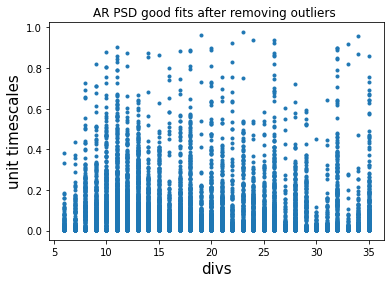

In [467]:
#remove outliers 
artau_rem_gf, ardivs_rem_gf, arcultures_rem_gf, arPSD_rem_gf = remove_outliers(np.asarray(artau_gfits), np.asarray(ardivs_gfits), np.asarray(arcultures_gfits), np.asarray(arPSD_gfits))

plt.plot(ardivs_rem_gf, artau_rem_gf, '.')
plt.ylabel('unit timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("AR PSD good fits after removing outliers ")


In [518]:
# get rsq values after removing outliers 

rsq_wPSD_rem_gf = []
rsq_arPSD_rem_gf = []


for w in wPSD_rem_gf:
    rsq_wPSD_rem_gf.append(w.rsq)
    
for ar in arPSD_rem_gf:
    rsq_arPSD_rem_gf.append(ar.rsq)
    


#### Calculated mean for each culture 

In [469]:
meanstd_wPSD_gf = get_mean_std_well(np.asarray(wtau_rem_gf), np.asarray(wdivs_rem_gf), np.asarray(wcultures_rem_gf) )

In [472]:
meanstd_arPSD_gf = get_mean_std_well(np.asarray(artau_rem_gf), np.asarray(ardivs_rem_gf), np.asarray(arcultures_rem_gf) )
                                     

##### Plot in linear scale

Text(0.5, 1.0, "Culture timescales Welch's PSD good fits")

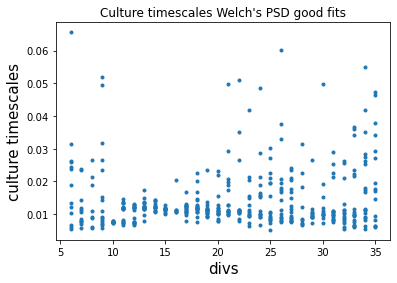

In [473]:
plt.plot(meanstd_wPSD_gf[1], meanstd_wPSD_gf[2], '.')
plt.ylabel('culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Culture timescales Welch's PSD good fits")

Text(0.5, 1.0, 'Culture timescales AR PSD good fits')

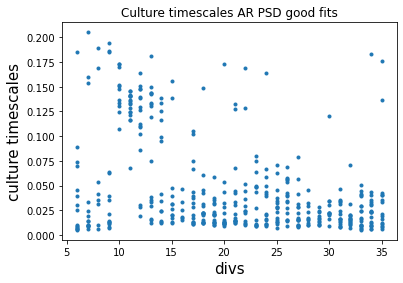

In [474]:
plt.plot(meanstd_arPSD_gf[1], meanstd_arPSD_gf[2], '.')
plt.ylabel('culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Culture timescales AR PSD good fits")

##### Plot in log scale

Text(0.5, 1.0, "Log culture timescales Welch's PSD good fits")

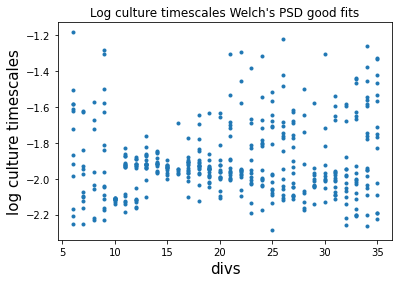

In [475]:
plt.plot(meanstd_wPSD_gf[1], np.log10(meanstd_wPSD_gf[2]), '.')
plt.ylabel('log culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Log culture timescales Welch's PSD good fits")

Text(0.5, 1.0, 'Log culture timescales AR PSD good fits')

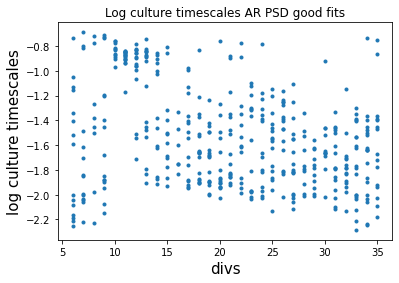

In [476]:
plt.plot(meanstd_arPSD_gf[1], np.log10(meanstd_arPSD_gf[2]), '.')
plt.ylabel('log culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Log culture timescales AR PSD good fits")

#### Mean and std for each culture 

##### Plot in linear scale

Text(0.5, 1.0, "Linear culture timescales Welch's PSD good fits")

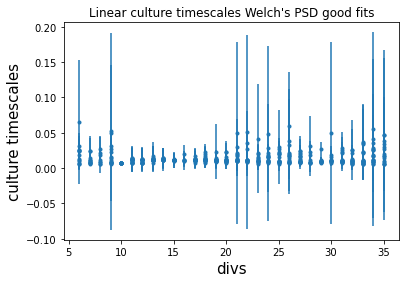

In [477]:
plt.errorbar(meanstd_wPSD_gf[1],meanstd_wPSD_gf[2], meanstd_wPSD_gf[3], linestyle='None', marker='.')
plt.ylabel('culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Linear culture timescales Welch's PSD good fits")


Text(0.5, 1.0, 'Linear culture timescales AR PSD good fits')

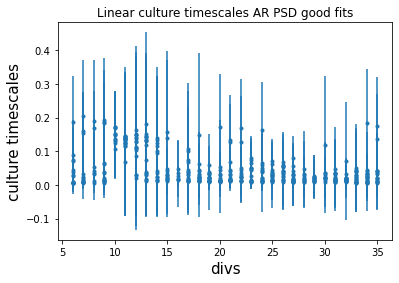

In [478]:
plt.errorbar(meanstd_arPSD_gf[1],meanstd_arPSD_gf[2], meanstd_arPSD_gf[3], linestyle='None', marker='.')
plt.ylabel('culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Linear culture timescales AR PSD good fits")


##### Plot in log scale

/var/folders/rr/tk8wmt7x4xlgzgmcy768y1rm0000gn/T/ipykernel_29532/1560154924.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.errorbar(meanstd_wPSD_gf[1],np.log10(meanstd_wPSD_gf[2]), np.log10(meanstd_wPSD_gf[3]), linestyle='None', marker='.')


Text(0.5, 1.0, "Log culture timescales Welch's PSD good fits")

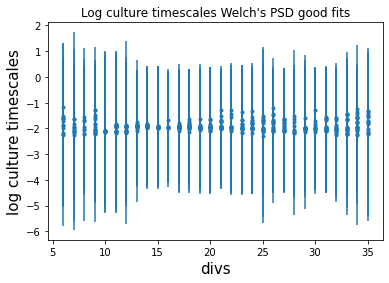

In [479]:
plt.errorbar(meanstd_wPSD_gf[1],np.log10(meanstd_wPSD_gf[2]), np.log10(meanstd_wPSD_gf[3]), linestyle='None', marker='.')
plt.ylabel('log culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Log culture timescales Welch's PSD good fits")

/var/folders/rr/tk8wmt7x4xlgzgmcy768y1rm0000gn/T/ipykernel_29532/3592072412.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.errorbar(meanstd_arPSD_gf[1],np.log10(meanstd_arPSD_gf[2]), np.log10(meanstd_arPSD_gf[3]), linestyle='None', marker='.')


Text(0.5, 1.0, 'Log culture timescales AR PSD good fits')

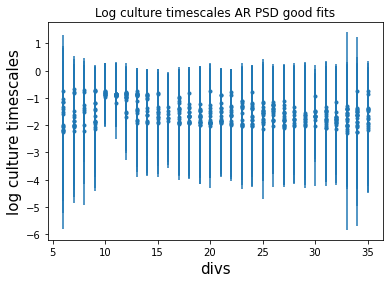

In [480]:
plt.errorbar(meanstd_arPSD_gf[1],np.log10(meanstd_arPSD_gf[2]), np.log10(meanstd_arPSD_gf[3]), linestyle='None', marker='.')
plt.ylabel('log culture timescales', size=15)
plt.xlabel('divs', size=15)
plt.title("Log culture timescales AR PSD good fits")

### Look at 7-20 divs time range in more detail

In [521]:
#get indices for 7-20 divs 
windices_720 = [i for i, x in enumerate(wdivs_rem_gf) if 7<x<20]

wcultures_720 = wcultures_rem_gf[indices_720]
wPSD_720 = wPSD_rem_gf[indices_720]
wtau_720 = wtau_rem_gf[indices_720]
wrsq_720 = np.asarray(rsq_wPSD_rem_gf)[indices_720]
wdivs_720 = wdivs_rem_gf[indices_720]

arindices_720 = [i for i, x in enumerate(ardivs_rem_gf) if 7<x<20]

arcultures_720 = arcultures_rem_gf[indices_720]
arPSD_720 = arPSD_rem_gf[indices_720]
artau_720 = artau_rem_gf[indices_720]
arrsq_720 = np.asarray(rsq_arPSD_rem_gf)[indices_720]
ardivs_720 = ardivs_rem_gf[indices_720]

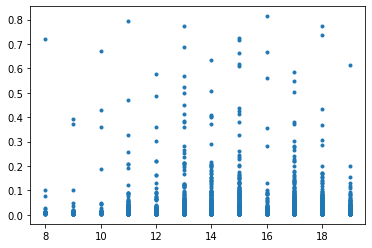

In [512]:
plt.plot(wdivs_720, wtau_720, '.')

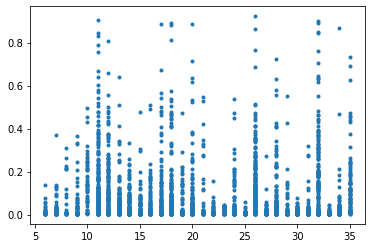

In [514]:
plt.plot(ardivs_720, artau_720, '.')

#### Plot r-squared values for this time range

Text(0.5, 1.0, 'Histogram of Welch PSD good (> 0.8) r-squared values in divs 7-20 after removing outliers')

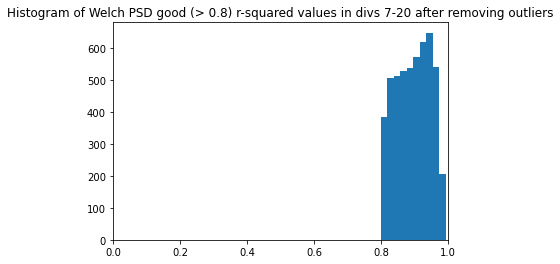

In [527]:
plt.hist(wrsq_720)
plt.xlim(0,1)
plt.title('Histogram of Welch PSD good (> 0.8) r-squared values in divs 7-20 after removing outliers')

(0.0, 1.01)

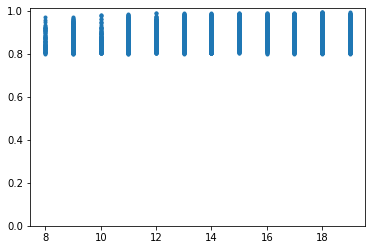

In [534]:
#plot rsq over divs
plt.plot(wdivs_720, wrsq_720, '.')
plt.ylim(0,1.01)

Text(0.5, 1.0, 'Histogram of AR PSD good (> 0.8) r-squared values in divs 7-20 after removing outliers')

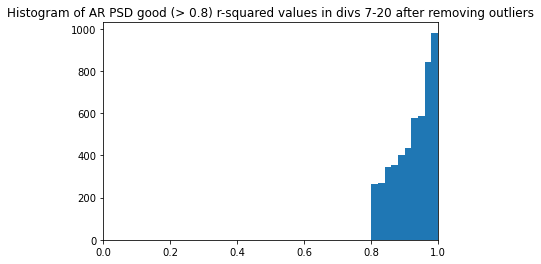

In [528]:
plt.hist(arrsq_720)
plt.xlim(0,1)
plt.title('Histogram of AR PSD good (> 0.8) r-squared values in divs 7-20 after removing outliers')

(0.0, 1.01)

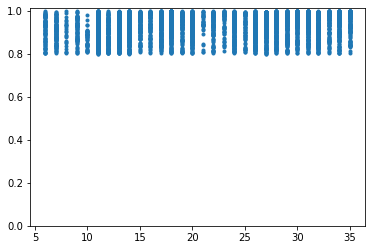

In [533]:
#plot rsq over divs
plt.plot(ardivs_720, arrsq_720, '.')
plt.ylim(0,1.01)

#### Plot PSDs for this time range